<a href="https://colab.research.google.com/github/Saichandu47/BERT_testing_on_IMDB_dataset/blob/main/BERT_testing_on_IMDB_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pattipatisaichandu","key":"8d0cd73bd381a7642b129f736f4a9f67"}'}

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d atulanandjha/imdb-50k-movie-reviews-test-your-bert

Dataset URL: https://www.kaggle.com/datasets/atulanandjha/imdb-50k-movie-reviews-test-your-bert
License(s): GNU Lesser General Public License 3.0
  0% 0.00/25.7M [00:00<?, ?B/s]
100% 25.7M/25.7M [00:00<00:00, 938MB/s]


In [7]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

**Disclaimer :** Before, we go any further, Let me clear that You would need **GPU** and **Internet**- toggle turned **ON** (install external libraries) to succesfully run this kernel.

![Begin](https://pbs.twimg.com/tweet_video_thumb/ECvtpBRXoAIpyUv.jpg)

Img source : https://pbs.twimg.com/tweet_video_thumb/ECvtpBRXoAIpyUv.jpg

In [8]:
# pytorch_pretained_bert already available in kaggle conda env.
!pip install pytorch-nlp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 4.0 MB/s eta 0:00:00


**Note :** uncomment the code line in above cell; you are running this notebook locally, and would need pytorch-nlp library.Here, it is pre-installed.

In [9]:
!pip install pytorch-pretrained-bert


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 78.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### importing necessaries libraries...

In [10]:
import sys
import numpy as np
import random as rn
import pandas as pd

import torch
from pytorch_pretrained_bert import BertModel
from torch import nn
# from torchnlp.datasets import imdb_dataset      # --> We are using our own uploaded dataset.
from pytorch_pretrained_bert import BertTokenizer
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

### Initializing seed values to stabilize the outcomes.

In [11]:
rn.seed(321)
np.random.seed(321)
torch.manual_seed(321)
torch.cuda.manual_seed(321)

## Prepare the data

In [12]:
!unzip imdb-50k-movie-reviews-test-your-bert.zip

Archive:  imdb-50k-movie-reviews-test-your-bert.zip
  inflating: test.csv                
  inflating: train.csv               


In [13]:
path = '/content/imdb-50k-movie-reviews-test-your-bert.zip'

train_data = pd.read_csv('/content/train.csv')
test_data = pd.read_csv('/content/test.csv')

In [14]:
# experimenting here with a sample of dataset, to avoid memory overflow.
train_data = train_data[:2000]
test_data = test_data[:500]

train_data = train_data.to_dict(orient='records')
test_data = test_data.to_dict(orient='records')
type(train_data)

list

### Mapping sentences with their Labels...

In [15]:
train_texts, train_labels = list(zip(*map(lambda d: (d['text'], d['sentiment']), train_data)))
test_texts, test_labels = list(zip(*map(lambda d: (d['text'], d['sentiment']), test_data)))

len(train_texts), len(train_labels), len(test_texts), len(test_labels)

(2000, 2000, 500, 500)

#### visualizing one of the sentences from train set

In [16]:
train_texts[0]

"Now, I won't deny that when I purchased this off eBay, I had high expectations. This was an incredible out-of-print work from the master of comedy that I so enjoy. However, I was soon to be disappointed. Apologies to those who enjoyed it, but I just found the Compleat Al to be very difficult to watch. I got a few smiles, sure, but the majority of the funny came from the music videos (which I've got on DVD) and the rest was basically filler. You could tell that this was not Al's greatest video achievement (that honor goes to UHF). Honestly, I doubt if this will ever make the jump to DVD, so if you're an ultra-hardcore Al fan and just HAVE to own everything, buy the tape off eBay. Just don't pay too much for it."

## visualizing sentences lengths

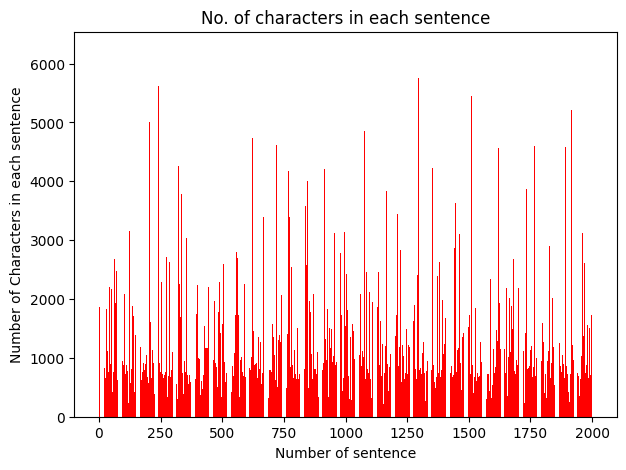

In [17]:
sentences = [len(sent) for sent in train_texts]

plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
plt.bar(range(1,2001), sentences, color = ['red'])
plt.gca().set(title='No. of characters in each sentence', xlabel='Number of sentence', ylabel='Number of Characters in each sentence');

#### We can see that most of the sentences are around 700 - 1000 characters long, which is pretty obvious. HOwever, few sentences are shorter and few even long as 6000 characters. So, this is a good, very versatile Review Dataset.

In [18]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

100%|██████████| 231508/231508 [00:00<00:00, 974570.16B/s]


In [19]:
tokenizer.tokenize('Hi my name is Atul')

['hi', 'my', 'name', 'is', 'at', '##ul']

### Sample of how BERT Tokenizer works and Embeddings prepared to be fed into BERT Model.

![BERT TOKENS](https://miro.medium.com/max/619/1*iJqlhZz-g6ZQJ53-rE9VvA.png)

## Preparing Token embeddings...

In [20]:
train_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:510] + ['[SEP]'], train_texts))
test_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:510] + ['[SEP]'], test_texts))

len(train_tokens), len(test_tokens)

(2000, 500)

## Preparing Token Ids...


![token ids](https://jalammar.github.io/images/distilBERT/sst2-text-to-tokenized-ids-bert-example.png)

In [21]:
train_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, train_tokens)), maxlen=512, truncating="post", padding="post", dtype="int")
test_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, test_tokens)), maxlen=512, truncating="post", padding="post", dtype="int")

train_tokens_ids.shape, test_tokens_ids.shape

((2000, 512), (500, 512))

### Many a times your Kernel will Freeze but this is just OK. Let it be. This is a heavy computing task; So,it is just a common thing to happen. I have also put Monitoring code snippets to monitor your CPU/GPU usage and also Garbage Collector to free up space.


It is quite common to see your CPU floating above 100% and/or GPU over 100% like these screens below:
![SNAP-1](https://i.ibb.co/3cFD5Hs/cut-1.png)
![SNAP-2](https://i.ibb.co/G5qFRxj/cut-2.png)

In [22]:
train_y = np.array(train_labels) == 'pos'
test_y = np.array(test_labels) == 'pos'
train_y.shape, test_y.shape, np.mean(train_y), np.mean(test_y)

((2000,), (500,), np.float64(0.4855), np.float64(0.508))

### Now Masking few random IDs from each sentences to remove Biasness from model.

In [23]:
train_masks = [[float(i > 0) for i in ii] for ii in train_tokens_ids]
test_masks = [[float(i > 0) for i in ii] for ii in test_tokens_ids]

# Baseline

In [24]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

In [25]:
baseline_model = make_pipeline(CountVectorizer(ngram_range=(1,3)), LogisticRegression()).fit(train_texts, train_labels)

In [26]:
baseline_predicted = baseline_model.predict(test_texts)

In [27]:
print(classification_report(test_labels, baseline_predicted))

              precision    recall  f1-score   support

         neg       0.82      0.84      0.83       246
         pos       0.84      0.83      0.83       254

    accuracy                           0.83       500
   macro avg       0.83      0.83      0.83       500
weighted avg       0.83      0.83      0.83       500



#### Our baseline model is working just fine and yeilding a fair enough score. Now, its time to play Dirty with the "BERT".

# BERT Model


### Bidirectional Encoder Representations from Transformers. Each word here has a meaning to it and we will encounter that one by one in this article. For now, the key takeaway from this line is – **BERT is based on the Transformer architecture**.

In [28]:
class BertBinaryClassifier(nn.Module):
    def __init__(self, dropout=0.1):
        super(BertBinaryClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased')

        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, tokens, masks=None):
        _, pooled_output = self.bert(tokens, attention_mask=masks, output_all_encoded_layers=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        proba = self.sigmoid(linear_output)
        return proba

In [29]:
# ensuring that the model runs on GPU, not on CPU

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [30]:
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'0.0M'

In [31]:
bert_clf = BertBinaryClassifier()
bert_clf = bert_clf.cuda()     # running BERT on CUDA_GPU

100%|██████████| 407873900/407873900 [00:14<00:00, 27659837.67B/s]


In [32]:
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'439.065088M'

In [33]:
x = torch.tensor(train_tokens_ids[:3]).to(device)
y, pooled = bert_clf.bert(x, output_all_encoded_layers=False)
x.shape, y.shape, pooled.shape

(torch.Size([3, 512]), torch.Size([3, 512, 768]), torch.Size([3, 768]))

In [34]:
y = bert_clf(x)
y.cpu().detach().numpy()        # kinda Garbage Collector to free up used and cache space

array([[0.40179852],
       [0.4417363 ],
       [0.38996655]], dtype=float32)

In [35]:
# Cross- checking CUDA GPU Memory to ensure GPU memory is not overflowing.
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'5799.899648M'

In [36]:
y, x, pooled = None, None, None
torch.cuda.empty_cache()     # Clearing Cache space for fresh Model run
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'447.584768M'

# Fine Tune BERT

In [37]:
# Setting hyper-parameters

BATCH_SIZE = 4
EPOCHS = 10

In [38]:
train_tokens_tensor = torch.tensor(train_tokens_ids)
train_y_tensor = torch.tensor(train_y.reshape(-1, 1)).float()

test_tokens_tensor = torch.tensor(test_tokens_ids)
test_y_tensor = torch.tensor(test_y.reshape(-1, 1)).float()

train_masks_tensor = torch.tensor(train_masks)
test_masks_tensor = torch.tensor(test_masks)

str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'447.584768M'

In [39]:
train_dataset = TensorDataset(train_tokens_tensor, train_masks_tensor, train_y_tensor)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

test_dataset = TensorDataset(test_tokens_tensor, test_masks_tensor, test_y_tensor)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

In [40]:
param_optimizer = list(bert_clf.sigmoid.named_parameters())
optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

In [41]:
optimizer = Adam(bert_clf.parameters(), lr=3e-6)

In [42]:
torch.cuda.empty_cache()   # Clearing Cache space for a fresh Model run

In [43]:
for epoch_num in range(EPOCHS):
    bert_clf.train()
    train_loss = 0
    for step_num, batch_data in enumerate(train_dataloader):
        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)
        print(str(torch.cuda.memory_allocated(device)/1000000 ) + 'M')
        logits = bert_clf(token_ids, masks)

        loss_func = nn.BCELoss()

        batch_loss = loss_func(logits, labels)
        train_loss += batch_loss.item()


        bert_clf.zero_grad()
        batch_loss.backward()


        clip_grad_norm_(parameters=bert_clf.parameters(), max_norm=1.0)
        optimizer.step()

        clear_output(wait=True)
        print('Epoch: ', epoch_num + 1)
        print("\r" + "{0}/{1} loss: {2} ".format(step_num, len(train_data) / BATCH_SIZE, train_loss / (step_num + 1)))

Epoch:  10
499/500.0 loss: 0.0282578137529199 


In [44]:
bert_clf.eval()
bert_predicted = []
all_logits = []
with torch.no_grad():
    for step_num, batch_data in enumerate(test_dataloader):

        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)

        logits = bert_clf(token_ids, masks)
        loss_func = nn.BCELoss()
        loss = loss_func(logits, labels)
        numpy_logits = logits.cpu().detach().numpy()

        bert_predicted += list(numpy_logits[:, 0] > 0.5)
        all_logits += list(numpy_logits[:, 0])


In [ ]:
np.mean(bert_predicted)

In [46]:
print(classification_report(test_y, bert_predicted))

              precision    recall  f1-score   support

       False       0.90      0.89      0.90       246
        True       0.89      0.91      0.90       254

    accuracy                           0.90       500
   macro avg       0.90      0.90      0.90       500
weighted avg       0.90      0.90      0.90       500



In [47]:
torch.save(bert_clf.state_dict(), "bert_imdb_model.pt")


In [48]:
!pip install pytorch-pretrained-bert gradio


In [52]:
import torch
from pytorch_pretrained_bert import BertTokenizer, BertModel
import gradio as gr
import torch.nn as nn
import torch.nn.functional as F

# Detect device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the BertBinaryClassifier class (same as PDF)
class BertBinaryClassifier(nn.Module):
    def __init__(self, dropout=0.1):
        super(BertBinaryClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, tokens, masks=None):
        _, pooled_output = self.bert(tokens, attention_mask=masks, output_all_encoded_layers=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        proba = self.sigmoid(linear_output)
        return proba

# Load tokenizer (same as training)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Load the fine-tuned model
model = BertBinaryClassifier()
model.load_state_dict(torch.load("bert_imdb_model.pt", map_location=device))
model.to(device)
model.eval()

# Prediction function
def predict_sentiment(review_text):
    try:
        if not review_text.strip():
            return "Error: Empty review text"

        # --- manual tokenization (pytorch_pretrained_bert has no encode_plus) ---
        tokens = tokenizer.tokenize(review_text)
        tokens = ["[CLS]"] + tokens + ["[SEP]"]
        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        max_len = 512
        if len(input_ids) < max_len:
            input_ids += [0] * (max_len - len(input_ids))
        else:
            input_ids = input_ids[:max_len]

        attention_mask = [1 if tid != 0 else 0 for tid in input_ids]

        input_ids = torch.tensor([input_ids]).to(device)
        attention_mask = torch.tensor([attention_mask]).to(device)

        with torch.no_grad():
            proba_pos = model(input_ids, masks=attention_mask).squeeze().item()
            proba_pos = max(0.0, min(1.0, proba_pos))  # clamp for safety

        is_positive = proba_pos >= 0.5
        label = "Positive" if is_positive else "Negative"
        confidence = proba_pos if is_positive else (1.0 - proba_pos)

        return f"{label} ({confidence*100:.2f}% confidence)"
    except Exception as e:
        return f"Error: {str(e)}"



# Launch Gradio app
iface = gr.Interface(
    fn=predict_sentiment,
    inputs=gr.Textbox(lines=4, placeholder="Enter a movie review..."),
    outputs="text",
    title="Movie Review Sentiment Analysis",
    description="Fine-tuned BERT on IMDB dataset using pytorch_pretrained_bert."
)

iface.launch()


Using device: cuda
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://34d174a292ea715d67.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [53]:
!pip install pytorch-pretrained-bert flask flask-ngrok
# Torch is usually preinstalled on Colab; if not:
# !pip install torch


In [54]:
torch.save(bert_clf.state_dict(), "bert_imdb_model.pt")


In [55]:
# write app.py and template files
app_py = r'''
from flask import Flask, request, render_template
import torch
from pytorch_pretrained_bert import BertTokenizer, BertModel
import torch.nn as nn

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Model class (same as your PDF)
class BertBinaryClassifier(nn.Module):
    def __init__(self, dropout=0.1):
        super(BertBinaryClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, tokens, masks=None):
        # note: older API returns (sequence_output, pooled_output)
        outputs = self.bert(tokens, attention_mask=masks)
        # outputs could be tuple or object; handle tuple
        if isinstance(outputs, tuple):
            pooled_output = outputs[1]
        else:
            pooled_output = outputs.pooler_output
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        proba = self.sigmoid(linear_output)
        return proba

# Load tokenizer & model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
model = BertBinaryClassifier()
model.load_state_dict(torch.load("bert_imdb_model.pt", map_location=device))
model.to(device)
model.eval()

app = Flask(__name__)

def predict_sentiment(text):
    # handle empty input
    if not text or not text.strip():
        return "Error: Empty review"

    # manual tokenization for pytorch_pretrained_bert
    tokens = tokenizer.tokenize(text)
    tokens = ["[CLS]"] + tokens + ["[SEP]"]
    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    max_len = 512
    if len(input_ids) < max_len:
        input_ids += [0] * (max_len - len(input_ids))
    else:
        input_ids = input_ids[:max_len]

    attention_mask = [1 if tid != 0 else 0 for tid in input_ids]

    input_ids = torch.tensor([input_ids]).to(device)
    attention_mask = torch.tensor([attention_mask]).to(device)

    with torch.no_grad():
        proba_pos = model(input_ids, masks=attention_mask).squeeze().item()
        proba_pos = max(0.0, min(1.0, proba_pos))

    is_pos = proba_pos >= 0.5
    label = "Positive" if is_pos else "Negative"
    confidence = proba_pos if is_pos else (1.0 - proba_pos)
    return f"{label} ({confidence*100:.2f}% confidence)"

@app.route('/', methods=['GET', 'POST'])
def index():
    result = ""
    if request.method == 'POST':
        text = request.form.get('review', '')
        try:
            result = predict_sentiment(text)
        except Exception as e:
            result = f"Error: {str(e)}"
    return render_template('index.html', result=result)

if __name__ == '__main__':
    # Use flask-ngrok to expose to web when running from Colab
    from flask_ngrok import run_with_ngrok
    run_with_ngrok(app)
    app.run()
'''
with open('app.py','w') as f:
    f.write(app_py)

html = r'''
<!DOCTYPE html>
<html>
<head>
    <meta charset="utf-8" />
    <title>Movie Review Sentiment</title>
    <style>
      body { font-family: Arial, sans-serif; background:#121212; color:#fff; text-align:center; }
      textarea { width:80%; height:160px; background:#1f1f1f; color:#fff; border:1px solid #333; padding:10px;}
      .btn { padding:12px 24px; background:#ff6b2d; color:#fff; border:none; cursor:pointer; }
      .result { margin-top:20px; font-size:18px; }
    </style>
</head>
<body>
    <h1>Movie Review Sentiment Analysis</h1>
    <p>Fine-tuned BERT on IMDB dataset (pytorch_pretrained_bert)</p>
    <form method="POST">
        <textarea name="review" placeholder="Enter review..."></textarea><br/><br/>
        <button class="btn" type="submit">Submit</button>
    </form>
    {% if result %}
      <div class="result"><strong>Result:</strong> {{ result }}</div>
    {% endif %}
</body>
</html>
'''
import os
os.makedirs('templates', exist_ok=True)
with open('templates/index.html','w') as f:
    f.write(html)

print("app.py and template created.")


app.py and template created.


In [ ]:
!python app.py


Using device: cuda
 * Serving Flask app 'app'
 * Debug mode: off
 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
Usage of ngrok requires a verified account and authtoken.

Sign up for an account: https://dashboard.ngrok.com/signup
Install your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken

ERR_NGROK_4018

Exception in thread Thread-1:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/urllib3/connection.py", line 198, in _new_conn
    sock = connection.create_connection(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/usr/local/lib/python3.11/dist-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr